In [1]:
#Importing Libraries

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
#Getting Images

Xtrain = []

destination_path = os.path.expanduser('mydata/train/')

for imagename in os.listdir('mydata/train/'):
    Xtrain.append(img_to_array(load_img(destination_path+imagename, target_size=(256, 256))))
Xtrain = np.array(Xtrain, dtype=float)

# Normalize data
Xtrain = 1.0/255*Xtrain

In [3]:
#CNN model

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
model.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
]

def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

In [5]:
import matplotlib.pyplot as plt

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model (500, 30)      
tensorboard = TensorBoard(log_dir="./output/beta_run")
trainedmodel = model.fit_generator(image_a_b_gen(batch_size), 
                                   callbacks=[tensorboard, LearningRateScheduler(scheduler, verbose=1), callbacks],
                                   epochs=40, 
                                   steps_per_epoch=30)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/40
 1/30 [>.............................] - ETA: 0s - loss: 0.0948 - accuracy: 0.7400WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 71s 2s/step - loss: 0.2711 - accuracy: 0.5459

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/40
30/30 [==============================] - 77s 3s/step - loss: 0.0244 - accuracy: 0.6683

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/40
30/30 [==============================] - 72s 2s/step - loss: 0.0305 - accuracy: 0.6642

Epoch 00004: LearningRateScheduler reducing learning rate 


Epoch 00020: LearningRateScheduler reducing learning rate to tf.Tensor(0.00040656968, shape=(), dtype=float32).
Epoch 20/40
30/30 [==============================] - 62s 2s/step - loss: 0.0217 - accuracy: 0.6992

Epoch 00021: LearningRateScheduler reducing learning rate to tf.Tensor(0.00036787946, shape=(), dtype=float32).
Epoch 21/40
30/30 [==============================] - 61s 2s/step - loss: 0.0203 - accuracy: 0.7093

Epoch 00022: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003328711, shape=(), dtype=float32).
Epoch 22/40
30/30 [==============================] - 78s 3s/step - loss: 0.0225 - accuracy: 0.6905

Epoch 00023: LearningRateScheduler reducing learning rate to tf.Tensor(0.0003011942, shape=(), dtype=float32).
Epoch 23/40
30/30 [==============================] - 67s 2s/step - loss: 0.0206 - accuracy: 0.6924

Epoch 00024: LearningRateScheduler reducing learning rate to tf.Tensor(0.00027253182, shape=(), dtype=float32).
Epoch 24/40
30/30 [======================

30/30 [==============================] - 68s 2s/step - loss: 0.0188 - accuracy: 0.6878

Epoch 00040: LearningRateScheduler reducing learning rate to tf.Tensor(5.5023218e-05, shape=(), dtype=float32).
Epoch 40/40
30/30 [==============================] - 66s 2s/step - loss: 0.0208 - accuracy: 0.6739


In [6]:
# Save model

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [7]:
# load json and create model

from tensorflow.keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

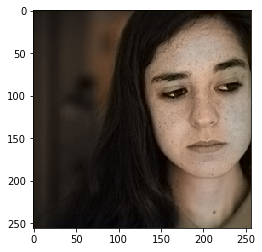

In [8]:
from pylab import *

img1_color = []

img1 = img_to_array(load_img('mydata/test/01.jpg'))
img1_color.append(img1)

img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255 * img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = loaded_model.predict(img1_color)
output1 = output1 * 128

result = np.zeros((256,256,3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imshow(lab2rgb(result))